In [1]:
import pandas  as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
import keras
from keras import backend as K
import tensorflow as tf
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## 2. Deep Networks

Se cargan los datos y se generan las matrices a trabajar.

In [2]:
df_sets = pd.read_csv("./koi_sets_unb.csv")
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_clean = (df_sets["Set"] != "Unlabeled").values
df_labels = pd.read_csv("./koi_labels.csv")
df_X = pd.read_csv("./koi_light_curves_X.csv")
df_labels_train = df_labels[mask_train]
df_labels_test = df_labels[mask_test]
df_X_train = df_X[mask_train]
df_X_test = df_X[mask_test]
df_X_clean = df_X[mask_clean]

y_train = ((df_labels_train["NExScI Disposition"]=="CONFIRMED")*1).values
y_test = ((df_labels_test["NExScI Disposition"]=="CONFIRMED")*1).values
df_X_train = df_X_train.reset_index(drop=True)
df_X_test = df_X_test.reset_index(drop=True)
df_X_train.fillna(df_X_train.median(), inplace=True)
df_X_test.fillna(df_X_test.median(), inplace=True)
X_train = df_X_train.values[:,1:]
X_test = df_X_test.values[:,1:]


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)

**a)** 

In [3]:
#modelo
model = Sequential()
model.add(Dense(1280, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='sigmoid'))
model.compile(optimizer=SGD(lr=0.01),loss='binary_crossentropy', metrics=['accuracy']) #compilar

###calculate gradients
loss = keras.losses.mean_squared_error(model.output,y_train)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

#entrenamiento
hist = model.fit(X_train_scaled, y_train, epochs=50, verbose=1, validation_split=0.2)

#gradiente salida
final_loss = keras.losses.mean_squared_error(model.output,y_train)
final_listOfVariableTensors = model.trainable_weights
final_gradients = K.gradients(final_loss, final_listOfVariableTensors)
sess = K.get_session()
final_evaluated_gradients = sess.run(final_gradients,feed_dict={model.input:X_train_scaled})
final_evaluated_gradients = [gradient/len(y_train) for gradient in final_evaluated_gradients]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 3753 samples, validate on 939 samples
Epoch 1/50
3753/3753 [==============================] - 2s 541us/step - loss: 0.6445 - acc: 0.6366 - val_loss: 0.6677 - val_acc: 0.5474
Epoch 2/50
3753/3753 [==============================] - 0s 80us/step - loss: 0.5983 - acc: 0.6613 - val_loss: 0.6242 - val_acc: 0.5474
Epoch 3/50
3753/3753 [==============================] - 0s 71us/step - loss: 0.5629 - acc: 0.6845 - val_loss: 0.5972 - val_acc: 0.5751
Epoch 4/50
3753/3753 [==============================] - 0s 78us/step - loss: 0.5311 - acc: 0.7301 - val_loss: 0.5494 - val_acc: 0.7220
Epoch 5/50
3753/3753 [==============================] - 0s 70us/step - loss: 0.5043 - acc: 0.7573 - val_loss: 0.5261 - val_acc: 0.8040
Epoch 6/50
3753/3753 [==============================] - 0s 72us/step - loss: 0.4796 - acc: 0.7914 - val_loss: 0.5591 - val_acc: 0.6081
Epoch 7/50
3753/3753 [

Gradientes previo al entrenamiento:


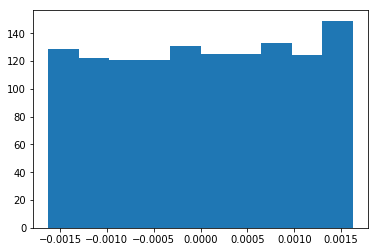

Gradientes posterior al entrenamiento:


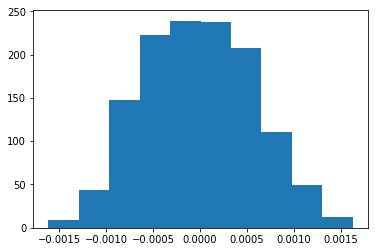

Comparacion de gradientes:


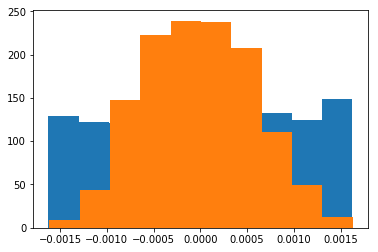

In [4]:
print("Gradientes previo al entrenamiento:")
plt.hist(evaluated_gradients[1])
plt.show()
print("Gradientes posterior al entrenamiento:")
plt.hist(final_evaluated_gradients[1])
plt.show()
print("Comparacion de gradientes:")
plt.hist(evaluated_gradients[1])
plt.hist(final_evaluated_gradients[1])
plt.show()

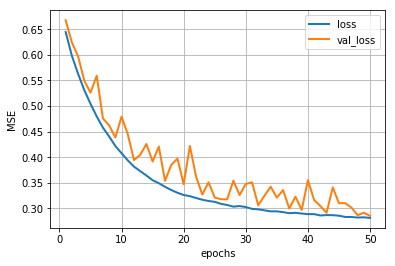

In [5]:
listaloss = []
listaval = []
for i in range(50):
    listaloss.append(hist.history['loss'][i])
    listaval.append(hist.history['val_loss'][i])

plt.plot(range(51)[1:],listaloss,label='loss', linewidth=2)
plt.plot(range(51)[1:],listaval,label='val_loss', linewidth=2)

plt.legend(['loss', 'val_loss'])
plt.ylabel('MSE')
plt.xlabel('epochs')
plt.grid(1)
plt.show()

En cada iteración la red neuronal actualiza cada peso en proporción a la grdiente de la función objetivo, pero cuando la gradiente es demasiado pequeña y deja de generar cambio en los pesos estos se estancan generando un problema. En los peores casos, dado el problema recien mencionado la red puede dejar de "aprender". En los histogramas se puede ver que las gradientes posterior al entrenamiento solo disminuyen en un orden de magnitud, esto debido justamente al problema de las gradientes descendientes explicado anteriormente.

**b)**

In [6]:
#modelo
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='sigmoid'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='binary_crossentropy',metrics=['accuracy'])

#gradiente
loss = keras.losses.mean_squared_error(model.output,y_train)
listOfVariableTensors = model.trainable_weights
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

#entrenamiento
hist = model.fit(X_train, y_train, epochs=50, verbose=1, validation_split=0.2)

#gradientes final
final_loss = tf.keras.losses.mean_squared_error(model.output,y_train)
final_listOfVariableTensors = model.trainable_weights
final_gradients = K.gradients(final_loss, final_listOfVariableTensors)
sess = K.get_session()
final_evaluated_gradients = sess.run(final_gradients,feed_dict={model.input:X_train_scaled})
final_evaluated_gradients = [gradient/len(y_train) for gradient in final_evaluated_gradients]

Train on 3753 samples, validate on 939 samples
Epoch 1/50
3753/3753 [==============================] - 1s 282us/step - loss: 0.6547 - acc: 0.6400 - val_loss: 0.7220 - val_acc: 0.5474
Epoch 2/50
3753/3753 [==============================] - 1s 170us/step - loss: 0.6547 - acc: 0.6400 - val_loss: 0.7027 - val_acc: 0.5474
Epoch 3/50
3753/3753 [==============================] - 1s 170us/step - loss: 0.6542 - acc: 0.6400 - val_loss: 0.7111 - val_acc: 0.5474
Epoch 4/50
3753/3753 [==============================] - 1s 172us/step - loss: 0.6547 - acc: 0.6400 - val_loss: 0.7084 - val_acc: 0.5474
Epoch 5/50
3753/3753 [==============================] - 1s 168us/step - loss: 0.6550 - acc: 0.6400 - val_loss: 0.7160 - val_acc: 0.5474
Epoch 6/50
3753/3753 [==============================] - 1s 173us/step - loss: 0.6548 - acc: 0.6400 - val_loss: 0.6918 - val_acc: 0.5474
Epoch 7/50
3753/3753 [==============================] - 1s 175us/step - loss: 0.6555 - acc: 0.6400 - val_loss: 0.6953 - val_acc: 0.5474
E

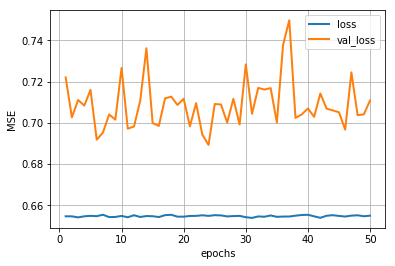

In [7]:
listaloss = []
listaval = []
for i in range(50):
    listaloss.append(hist.history['loss'][i])
    listaval.append(hist.history['val_loss'][i])

plt.plot(range(51)[1:],listaloss,label='loss', linewidth=2)
plt.plot(range(51)[1:],listaval,label='val_loss', linewidth=2)

plt.legend(['loss', 'val_loss'])
plt.ylabel('MSE')
plt.xlabel('epochs')
plt.grid(1)
plt.show()

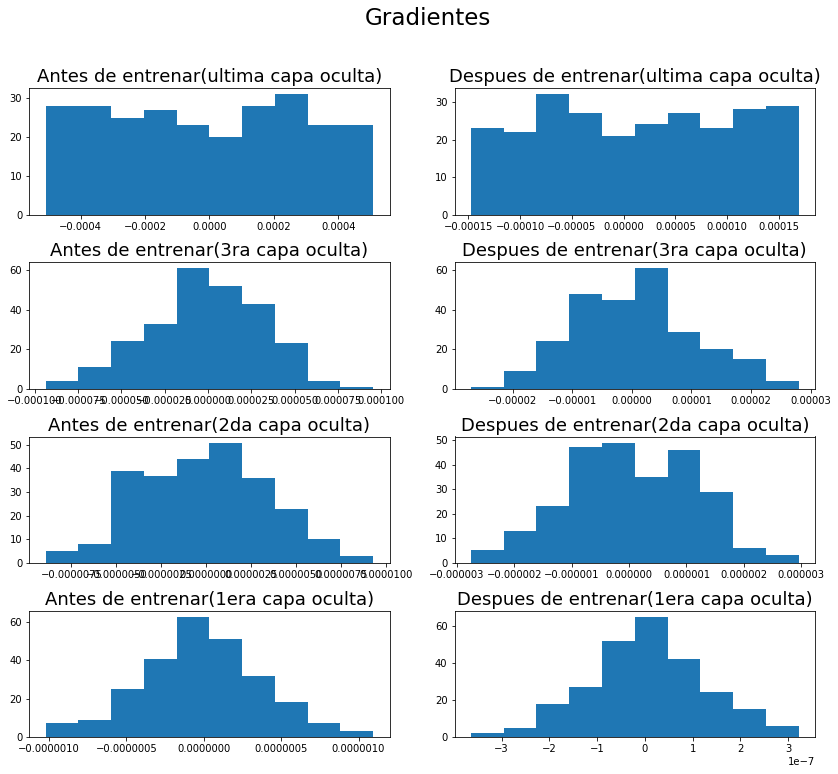

In [8]:
plt.figure(1, figsize=(12,10))
plt.suptitle("Gradientes", fontsize=23, y=1.07)

plt.subplot(421)
plt.title("Antes de entrenar(ultima capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[9])

plt.subplot(422)
plt.title("Despues de entrenar(ultima capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[9])

plt.subplot(423)
plt.title("Antes de entrenar(3ra capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[7])

plt.subplot(424)
plt.title("Despues de entrenar(3ra capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[7])

plt.subplot(425)
plt.title("Antes de entrenar(2da capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[5])

plt.subplot(426)
plt.title("Despues de entrenar(2da capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[5])

plt.subplot(427)
plt.title("Antes de entrenar(1era capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[3])

plt.subplot(428)
plt.title("Despues de entrenar(1era capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[3])

plt.tight_layout()
plt.show()

**c)**

In [9]:
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='glorot_uniform',activation='sigmoid'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='binary_crossentropy', metrics=['accuracy'])
loss = keras.losses.mean_squared_error(model.output,y_train)
listOfVariableTensors = model.trainable_weights

gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

hist = model.fit(X_train, y_train, epochs=50, verbose=1, validation_split=0.2)

Train on 3753 samples, validate on 939 samples
Epoch 1/50
3753/3753 [==============================] - 1s 250us/step - loss: 0.6553 - acc: 0.6400 - val_loss: 0.7113 - val_acc: 0.5474
Epoch 2/50
3753/3753 [==============================] - 1s 171us/step - loss: 0.6547 - acc: 0.6400 - val_loss: 0.7080 - val_acc: 0.5474
Epoch 3/50
3753/3753 [==============================] - 1s 187us/step - loss: 0.6549 - acc: 0.6400 - val_loss: 0.6944 - val_acc: 0.5474
Epoch 4/50
3753/3753 [==============================] - 1s 162us/step - loss: 0.6558 - acc: 0.6400 - val_loss: 0.7023 - val_acc: 0.5474
Epoch 5/50
3753/3753 [==============================] - 1s 200us/step - loss: 0.6547 - acc: 0.6400 - val_loss: 0.7153 - val_acc: 0.5474
Epoch 6/50
3753/3753 [==============================] - 1s 168us/step - loss: 0.6556 - acc: 0.6400 - val_loss: 0.7077 - val_acc: 0.5474
Epoch 7/50
3753/3753 [==============================] - 1s 191us/step - loss: 0.6554 - acc: 0.6400 - val_loss: 0.7170 - val_acc: 0.5474
E

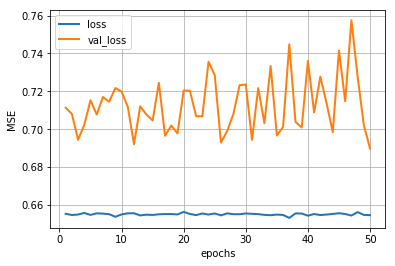

In [10]:
listaloss = []
listaval = []
for i in range(50):
    listaloss.append(hist.history['loss'][i])
    listaval.append(hist.history['val_loss'][i])

plt.plot(range(51)[1:],listaloss,label='loss', linewidth=2)
plt.plot(range(51)[1:],listaval,label='val_loss', linewidth=2)

plt.legend(['loss', 'val_loss'])
plt.ylabel('MSE')
plt.xlabel('epochs')
plt.grid(1)
plt.show()

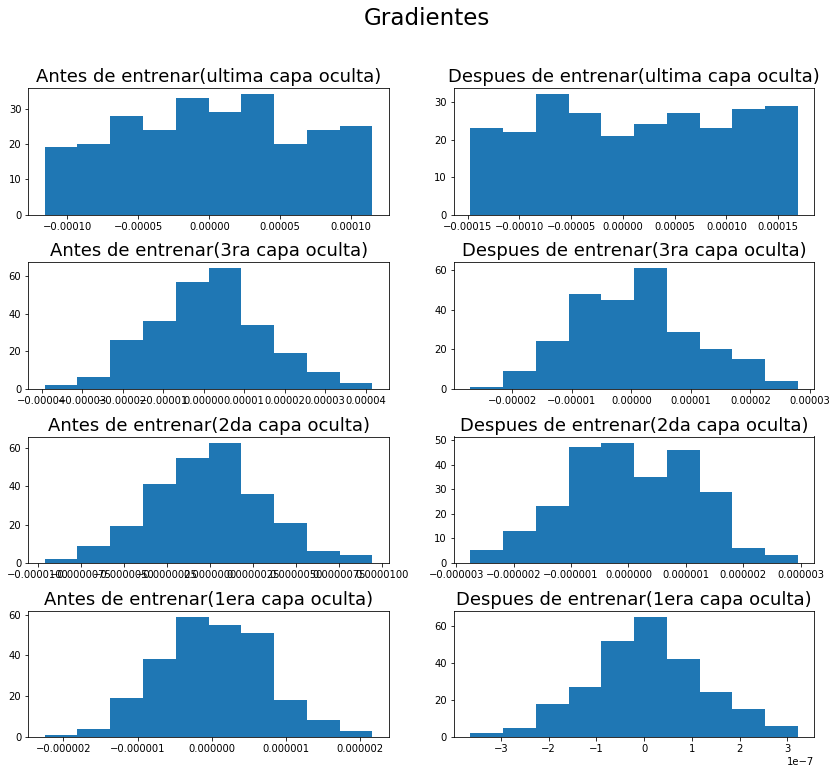

In [11]:
plt.figure(1, figsize=(12,10))
plt.suptitle("Gradientes", fontsize=23, y=1.07)

plt.subplot(421)
plt.title("Antes de entrenar(ultima capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[9])

plt.subplot(422)
plt.title("Despues de entrenar(ultima capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[9])

plt.subplot(423)
plt.title("Antes de entrenar(3ra capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[7])

plt.subplot(424)
plt.title("Despues de entrenar(3ra capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[7])

plt.subplot(425)
plt.title("Antes de entrenar(2da capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[5])

plt.subplot(426)
plt.title("Despues de entrenar(2da capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[5])

plt.subplot(427)
plt.title("Antes de entrenar(1era capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[3])

plt.subplot(428)
plt.title("Despues de entrenar(1era capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[3])

plt.tight_layout()
plt.show()

**d)**

In [12]:
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], kernel_initializer='uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model.add(Dense(1, kernel_initializer='uniform',activation='sigmoid'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='binary_crossentropy',metrics=['accuracy'])
loss = keras.losses.mean_squared_error(model.output,y_train)
listOfVariableTensors = model.trainable_weights

gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

hist = model.fit(X_train, y_train, epochs=50, verbose=1, validation_split=0.2)

Train on 3753 samples, validate on 939 samples
Epoch 1/50
3753/3753 [==============================] - 1s 289us/step - loss: 5.8022 - acc: 0.6400 - val_loss: 7.2952 - val_acc: 0.5474
Epoch 2/50
3753/3753 [==============================] - 1s 192us/step - loss: 5.8022 - acc: 0.6400 - val_loss: 7.2952 - val_acc: 0.5474
Epoch 3/50
3753/3753 [==============================] - 1s 177us/step - loss: 5.8022 - acc: 0.6400 - val_loss: 7.2952 - val_acc: 0.5474
Epoch 4/50
3753/3753 [==============================] - 1s 173us/step - loss: 5.8022 - acc: 0.6400 - val_loss: 7.2952 - val_acc: 0.5474
Epoch 5/50
3753/3753 [==============================] - 1s 194us/step - loss: 5.8022 - acc: 0.6400 - val_loss: 7.2952 - val_acc: 0.5474
Epoch 6/50
3753/3753 [==============================] - 1s 178us/step - loss: 5.8022 - acc: 0.6400 - val_loss: 7.2952 - val_acc: 0.5474
Epoch 7/50
3753/3753 [==============================] - 1s 175us/step - loss: 5.8022 - acc: 0.6400 - val_loss: 7.2952 - val_acc: 0.5474
E

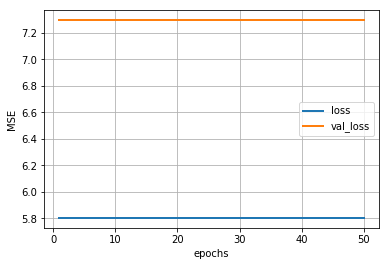

In [13]:
listaloss = []
listaval = []
for i in range(50):
    listaloss.append(hist.history['loss'][i])
    listaval.append(hist.history['val_loss'][i])

plt.plot(range(51)[1:],listaloss,label='loss', linewidth=2)
plt.plot(range(51)[1:],listaval,label='val_loss', linewidth=2)

plt.legend(['loss', 'val_loss'])
plt.ylabel('MSE')
plt.xlabel('epochs')
plt.grid(1)
plt.show()

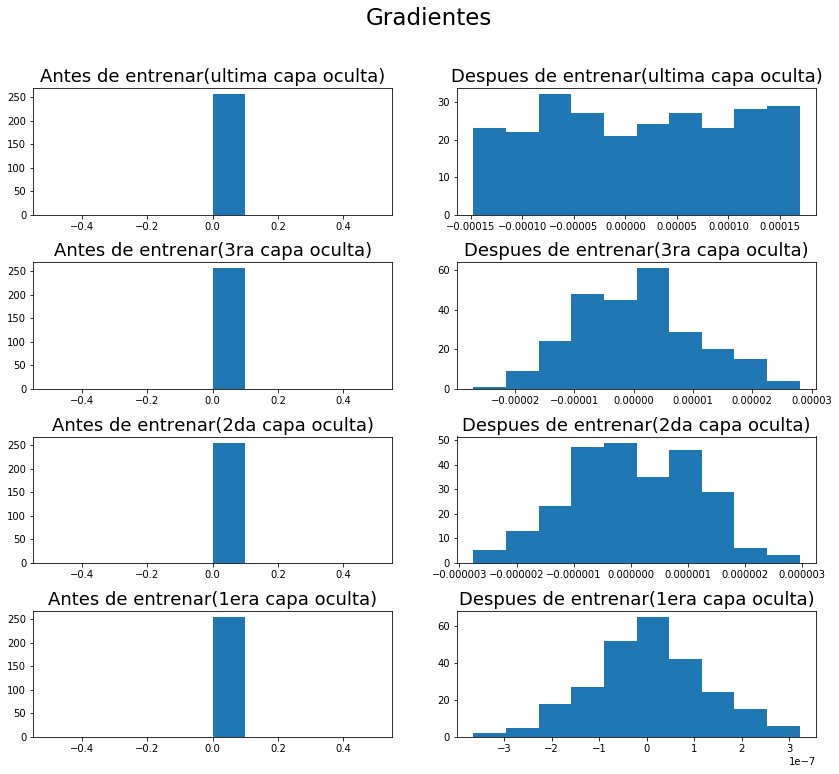

In [14]:
plt.figure(1, figsize=(12,10))
plt.suptitle("Gradientes", fontsize=23, y=1.07)

plt.subplot(421)
plt.title("Antes de entrenar(ultima capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[9])

plt.subplot(422)
plt.title("Despues de entrenar(ultima capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[9])

plt.subplot(423)
plt.title("Antes de entrenar(3ra capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[7])

plt.subplot(424)
plt.title("Despues de entrenar(3ra capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[7])

plt.subplot(425)
plt.title("Antes de entrenar(2da capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[5])

plt.subplot(426)
plt.title("Despues de entrenar(2da capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[5])

plt.subplot(427)
plt.title("Antes de entrenar(1era capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[3])

plt.subplot(428)
plt.title("Despues de entrenar(1era capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[3])

plt.tight_layout()
plt.show()

**e)**

In [15]:
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], kernel_initializer='he_uniform',activation='softplus'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='softplus'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='softplus'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='softplus'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='softplus'))
model.add(Dense(1, kernel_initializer='he_uniform',activation='sigmoid'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='binary_crossentropy', metrics=['accuracy'])
loss = keras.losses.mean_squared_error(model.output,y_train)
listOfVariableTensors = model.trainable_weights

gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

hist = model.fit(X_train, y_train, epochs=50, verbose=1, validation_split=0.2)

Train on 3753 samples, validate on 939 samples
Epoch 1/50
3753/3753 [==============================] - 1s 298us/step - loss: 8.5378 - acc: 0.4684 - val_loss: 9.4514 - val_acc: 0.4121
Epoch 2/50
3753/3753 [==============================] - 1s 193us/step - loss: 8.5378 - acc: 0.4684 - val_loss: 9.4514 - val_acc: 0.4121
Epoch 3/50
3753/3753 [==============================] - 1s 212us/step - loss: 8.5378 - acc: 0.4684 - val_loss: 9.4514 - val_acc: 0.4121
Epoch 4/50
3753/3753 [==============================] - 1s 204us/step - loss: 8.5378 - acc: 0.4684 - val_loss: 9.4514 - val_acc: 0.4121
Epoch 5/50
3753/3753 [==============================] - 1s 211us/step - loss: 8.5378 - acc: 0.4684 - val_loss: 9.4514 - val_acc: 0.4121
Epoch 6/50
3753/3753 [==============================] - 1s 215us/step - loss: 8.5378 - acc: 0.4684 - val_loss: 9.4514 - val_acc: 0.4121
Epoch 7/50
3753/3753 [==============================] - 1s 234us/step - loss: 8.5378 - acc: 0.4684 - val_loss: 9.4514 - val_acc: 0.4121
E

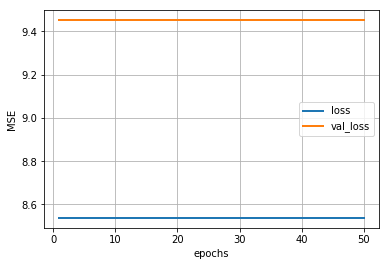

In [18]:
listaloss = []
listaval = []
for i in range(50):
    listaloss.append(hist.history['loss'][i])
    listaval.append(hist.history['val_loss'][i])

plt.plot(range(51)[1:],listaloss,label='loss', linewidth=2)
plt.plot(range(51)[1:],listaval,label='val_loss', linewidth=2)

plt.legend(['loss', 'val_loss'])
plt.ylabel('MSE')
plt.xlabel('epochs')
plt.grid(1)
plt.show()

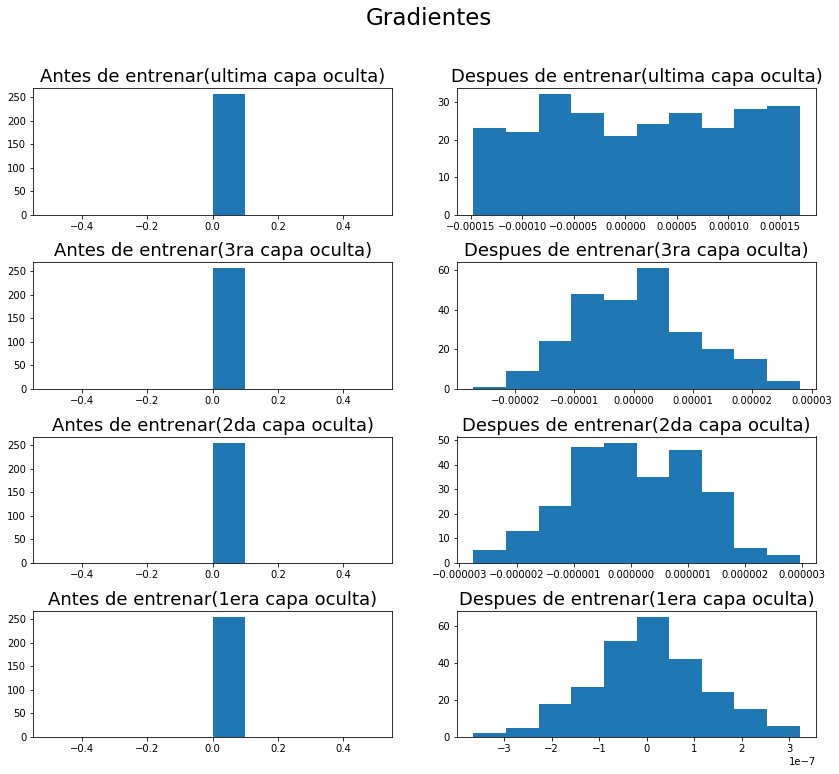

In [19]:
plt.figure(1, figsize=(12,10))
plt.suptitle("Gradientes", fontsize=23, y=1.07)

plt.subplot(421)
plt.title("Antes de entrenar(ultima capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[9])

plt.subplot(422)
plt.title("Despues de entrenar(ultima capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[9])

plt.subplot(423)
plt.title("Antes de entrenar(3ra capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[7])

plt.subplot(424)
plt.title("Despues de entrenar(3ra capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[7])

plt.subplot(425)
plt.title("Antes de entrenar(2da capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[5])

plt.subplot(426)
plt.title("Despues de entrenar(2da capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[5])

plt.subplot(427)
plt.title("Antes de entrenar(1era capa oculta)",fontsize=18)
plt.hist(evaluated_gradients[3])

plt.subplot(428)
plt.title("Despues de entrenar(1era capa oculta)",fontsize=18)
plt.hist(final_evaluated_gradients[3])

plt.tight_layout()
plt.show()

**f)**

In [ ]:
model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], kernel_initializer='he_uniform',activation='softplus'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='softplus'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='softplus'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='softplus'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='softplus'))
model.add(Dense(1, kernel_initializer='he_uniform',activation='sigmoid'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='binary_crossentropy', metrics=['accuracy'])
loss = keras.losses.mean_squared_error(model.output,y_train)
listOfVariableTensors = model.trainable_weights

gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]

hist = model.fit(X_train, y_train, epochs=50, verbose=1, validation_split=0.2)

In [ ]:
from keras.layers import LeakyReLU, PReLU, ELU, ThresholdedReLU
LeakyReLU(alpha=0.3)
PReLU(alpha_initializer='zeros')
ELU(alpha=1.0)
ThresholdedReLU(theta=1.0)
...
model.add(Dense(nh, activation='linear'))
model.add(LeakyReLU(alpha=0.3))

**g)**